In [91]:
import os
import re
import numpy as np
from rt_utils import RTStructBuilder
import matplotlib.pyplot as plt
import pydicom 
CT_PATH = './CT_Slices'

In [73]:
def transform_to_hu(medical_image):
    intercept = medical_image.RescaleIntercept
    slope = medical_image.RescaleSlope
    image = medical_image.pixel_array
    hu_image = image * slope + intercept

    return hu_image

def apply_windowing(ds, window_center, window_width):
    # Load the DICOM file
    
    # Get the pixel data and rescale to Hounsfield units (HU)
    pixel_array = ds.pixel_array.astype(np.float32)
    intercept = ds.RescaleIntercept
    slope = ds.RescaleSlope
    hu_array = pixel_array * slope + intercept
    
    # Apply windowing
    window_min = window_center - (window_width / 2)
    window_max = window_center + (window_width / 2)
    windowed_array = np.clip(hu_array, window_min, window_max)
    
    # Normalize the windowed array to [0, 1]
    normalized_array = (windowed_array - window_min) / (window_max - window_min)
    
    return normalized_array


def set_window(img, hu=[-800.,1200.]):
    window = np.array(hu)
    newimg = (img-window[0]) / (window[1]-window[0])
    newimg[newimg < 0] = 0
    newimg[newimg > 1] = 1
    newimg = (newimg * 255).astype('uint8')
    return newimg


def zero_center(hu_image):
    hu_image = hu_image - np.mean(hu_image)
    return hu_image

In [ ]:
def rename_folders(path):
    for patient in os.listdir(path):
        old_path = os.path.join(path, patient)
        new_name = re.sub(r'[^0-9]','',patient)
        new_path = os.path.join(path, new_name)
        os.rename(old_path, new_name)
        
rename_folders(CT_PATH)

In [6]:
DATA_PATH = './data/'

In [22]:
import shutil
def create_ds_structure(path):
    for patient in os.listdir(path):
        p_path = os.path.join(path, patient)
        dicom_path = os.path.join(p_path, 'dicom')
        r_path = os.path.join(p_path, 'r')
        if not os.path.exists(dicom_path):
            os.mkdir(dicom_path)
        if not os.path.exists(r_path):
            os.mkdir(r_path)
        for file in os.listdir(p_path):
            file_path = os.path.join(p_path, file)
            if os.path.isfile(file_path):
                if(file[0:2]=='CT'):
                    new_path = os.path.join(dicom_path, file)
                    shutil.move(file_path, new_path)
                if(file[0:2]=='RS'):
                    new_path = os.path.join(r_path, file)
                    shutil.move(file_path, new_path)

        

create_ds_structure(DATA_PATH)    




In [81]:


# Load existing RT Struct. Requires the series path and existing RT Struct path
rtstruct = RTStructBuilder.create_from(
  dicom_series_path="./data/01/dicom", 
  rt_struct_path="./data/01/r/RS.1.2.410.200018.1001.1.3.89143765.2.20151123111228992.dcm"
)

# View all of the ROI names from within the image
print(rtstruct.get_roi_names())
ds = []
for image in os.listdir('./data/01/dicom/'):
  img_path = os.path.join('./data/01/dicom/', image)
  ds.append(pydicom.dcmread(img_path))



rtstruct

IsADirectoryError: [Errno 21] Is a directory: './data/01/r/'

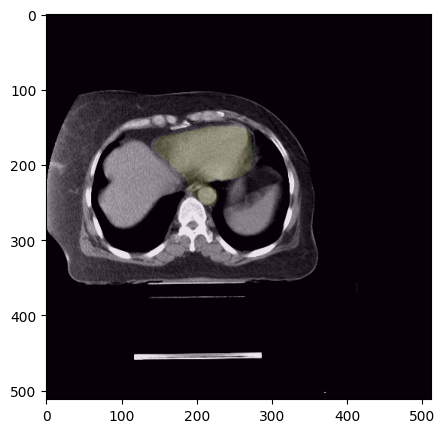

In [90]:
img_idx = 33
mask_idx = 44 -img_idx
ds_img = apply_windowing(ds[img_idx], 35, 350)
# Loading the 3D Mask from within the RT Struct
mask_3d = rtstruct.get_roi_mask_by_name("heart")


fliped = np.flip(mask_3d, axis=2)
# Display one slice of the region
first_mask_slice = fliped[:, :, img_idx]
plt.figure(figsize = (5,5))
plt.imshow(first_mask_slice)
plt.imshow(ds_img, cmap='gray',alpha=0.9)

In [55]:
ds_2 = rtstruct.ds

In [ ]:
def create_2d_dataset(path):
    for patient in os.listdir(path):
        dicom_path = os.path.join(p_path, 'dicom')
        r_path = os.path.join(p_path, 'r')
        r_file = os.scandir(r_path)
        rtstruct = RTStructBuilder.create_from(
                    dicom_series_path=dicom_path, 
                    rt_struct_path=r_file
        )
        mask_3d = rtstruct.get_roi_mask_by_name("heart")
        fliped = np.flip(mask_3d, axis=2)

        plt.imshow(mask_3d[:,:,33])
        p_path = os.path.join(path, patient)
        
        

create_2d_dataset(DATA_PATH)